In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


import os

# Load and Visualize the data

In [2]:
df = pd.read_csv("./Data/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


1    165
0    138
Name: target, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

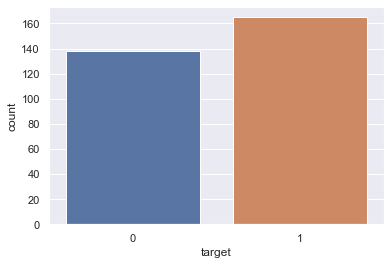

In [3]:
print(df.target.value_counts())
sns.countplot(x='target', data=df)
plt.show

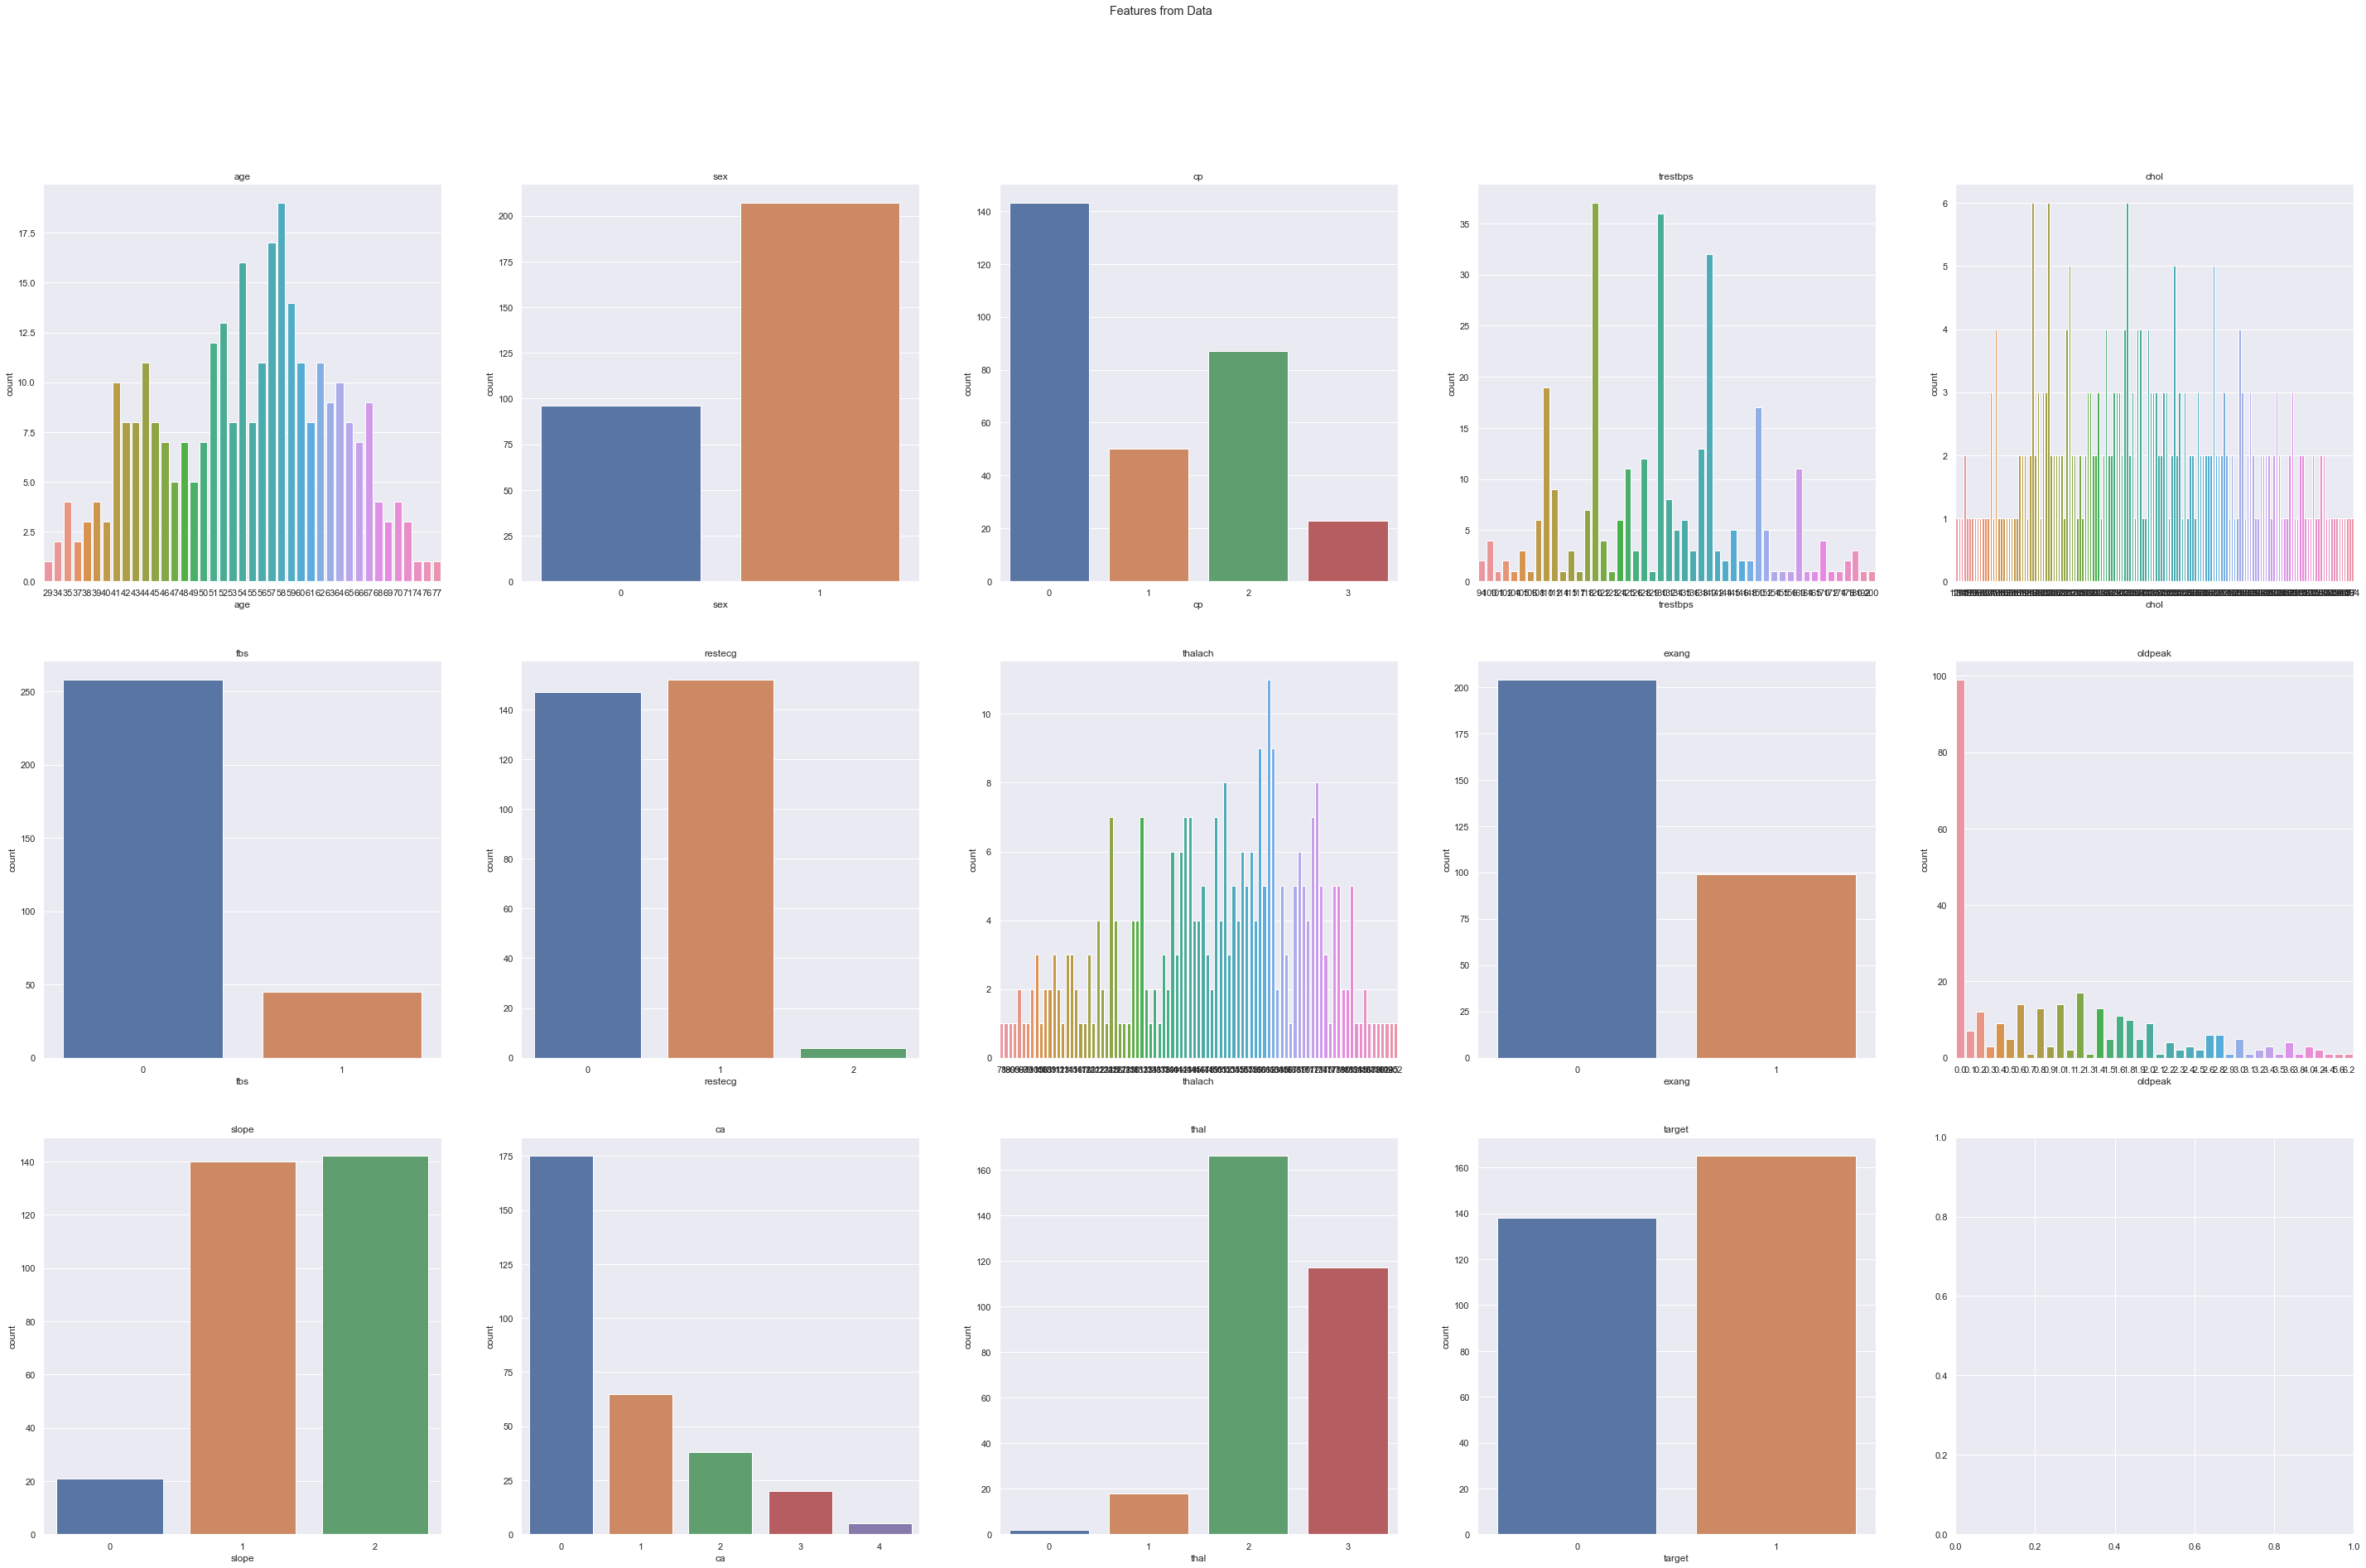

In [4]:
fig, axes = plt.subplots(3, 5)
fig.suptitle('Features from Data')
fig.set_size_inches(50, 30)

for feature, ax in zip(df.columns, axes.flatten()):
    ax.set_title(feature)
    sns.countplot(x=feature, ax=ax, data=df)

## Split the data into train and test sets

In [5]:
train, test = train_test_split(df, test_size=0.2)

print(f'{len(train)} entries in training set')
print(f'{len(test)} entries in testing set')

X_train = train.drop('target', axis=1)  #creates a new dataframe, does not actually modify df
Y_train = train['target']

X_test = test.drop('target', axis=1)
Y_test = test['target']

train.head()

242 entries in training set
61 entries in testing set


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
270,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
68,44,1,1,120,220,0,1,170,0,0.0,2,0,2,1
116,41,1,2,130,214,0,0,168,0,2.0,1,0,2,1
267,49,1,2,118,149,0,0,126,0,0.8,2,3,2,0
276,58,1,0,146,218,0,1,105,0,2.0,1,1,3,0


In [6]:
def make_confusion_matrix(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Decision Tree

In [7]:
from sklearn import tree


decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

decision_tree_score = decision_tree.score(X_test, Y_test)

              precision    recall  f1-score   support

           0       0.68      0.84      0.75        25
           1       0.87      0.72      0.79        36

    accuracy                           0.77        61
   macro avg       0.77      0.78      0.77        61
weighted avg       0.79      0.77      0.77        61

0.7704918032786885


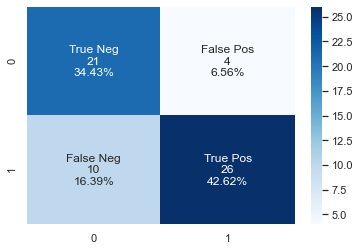

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Y_pred = decision_tree.predict(X_test)

matrix = confusion_matrix(Y_test, Y_pred)

print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

make_confusion_matrix(matrix)

In [9]:
import graphviz

dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                     feature_names=X_test.columns,  
                     #class_names=['True', 'False'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render(filename='decision_tree')

'decision_tree.pdf'

# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=20, random_state=0, max_depth=4)
random_forest.fit(X_train, Y_train)

random_forest_score = random_forest.score(X_test, Y_test)

              precision    recall  f1-score   support

           0       0.63      0.68      0.65        25
           1       0.76      0.72      0.74        36

    accuracy                           0.70        61
   macro avg       0.70      0.70      0.70        61
weighted avg       0.71      0.70      0.71        61

0.7049180327868853


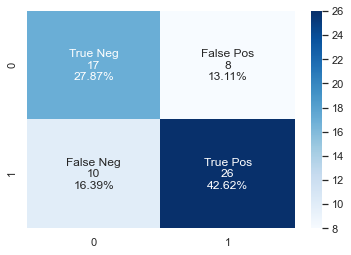

In [11]:
Y_pred = random_forest.predict(X_test)


print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

make_confusion_matrix(confusion_matrix(Y_test, Y_pred))


In [12]:
from sklearn.tree import export_graphviz


def get_forest_image(estimator, filename):
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names=X_test.columns,  
                    #class_names=['True', 'False'],  
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', filename, '-Gdpi=600'])

    # Display in jupyter notebook
    from IPython.display import Image
    Image(filename = filename)

In [13]:
for i in range(5):
    estimator = random_forest.estimators_[i]

    get_forest_image(estimator, f'randomforest{i}.png')

# Naive Bayes

In [14]:
def normalize(x):
    x = x.values

    min_max_scalar = preprocessing.MinMaxScaler()
    x_scaled = min_max_scalar.fit_transform(x)

    df = pd.DataFrame(x_scaled)
    return df

In [15]:
from sklearn.naive_bayes import GaussianNB

X_test = normalize(X_test)
X_train = normalize(X_train)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

naive_bayes_score = gnb.score(X_test, Y_test)

              precision    recall  f1-score   support

           0       0.61      0.76      0.68        25
           1       0.80      0.67      0.73        36

    accuracy                           0.70        61
   macro avg       0.71      0.71      0.70        61
weighted avg       0.72      0.70      0.71        61

0.7049180327868853


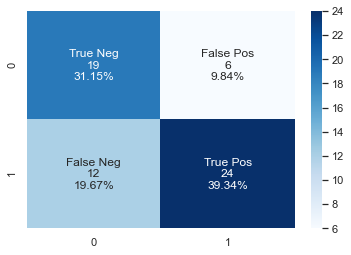

In [16]:
Y_pred = gnb.predict(X_test)


print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

make_confusion_matrix(confusion_matrix(Y_test, Y_pred))

# Support Vector Machine

In [25]:
from sklearn import svm


clf = svm.SVC()

clf.fit(X_train, Y_train)

svm_score = clf.score(X_test, Y_test)

print(clf.n_support_)

[57 63]


              precision    recall  f1-score   support

           0       0.74      0.68      0.71        25
           1       0.79      0.83      0.81        36

    accuracy                           0.77        61
   macro avg       0.76      0.76      0.76        61
weighted avg       0.77      0.77      0.77        61

0.7704918032786885


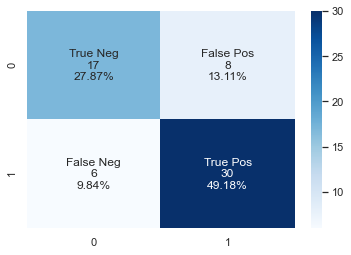

In [18]:
Y_pred = clf.predict(X_test)

print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

make_confusion_matrix(confusion_matrix(Y_test, Y_pred))

# Neural Network

In [32]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-7, random_state=1, max_iter=500, hidden_layer_sizes=(5,5))

clf.fit(X_train, Y_train)

mlp_score = clf.score(X_test, Y_test)



In [33]:
print(clf.hidden_layer_sizes)

(5, 5)


              precision    recall  f1-score   support

           0       0.65      0.68      0.67        25
           1       0.77      0.75      0.76        36

    accuracy                           0.72        61
   macro avg       0.71      0.72      0.71        61
weighted avg       0.72      0.72      0.72        61

0.7213114754098361


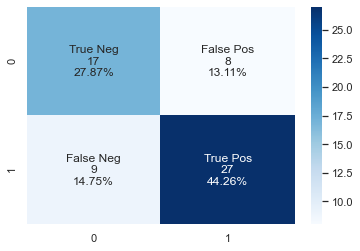

In [34]:
Y_pred = clf.predict(X_test)

print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

make_confusion_matrix(confusion_matrix(Y_test, Y_pred))

# Comparison of the different models

In [23]:
def run_dt(df):
    train, test = train_test_split(df, test_size=0.2)
    X_train = train.drop('target', axis=1)  #creates a new dataframe, does not actually modify df
    Y_train = train['target']
    X_test = test.drop('target', axis=1)
    Y_test = test['target']

    decision_tree = tree.DecisionTreeClassifier()
    decision_tree.fit(X_train, Y_train)
    return decision_tree.score(X_test, Y_test)


def run_nb(df):
    train, test = train_test_split(df, test_size=0.2)
    X_train = train.drop('target', axis=1)  #creates a new dataframe, does not actually modify df
    Y_train = train['target']
    X_test = test.drop('target', axis=1)
    Y_test = test['target']

    gnb = GaussianNB()
    gnb.fit(X_train, Y_train)
    return gnb.score(X_test, Y_test)


def run_rf(df):
    train, test = train_test_split(df, test_size=0.2)
    X_train = train.drop('target', axis=1)  #creates a new dataframe, does not actually modify df
    Y_train = train['target']
    X_test = test.drop('target', axis=1)
    Y_test = test['target']

    random_forest = RandomForestClassifier(n_estimators=15, random_state=0, max_depth=5)
    random_forest.fit(X_train, Y_train)
    return random_forest.score(X_test, Y_test)


def run_svm(df):
    train, test = train_test_split(df, test_size=0.2)
    X_train = train.drop('target', axis=1)  #creates a new dataframe, does not actually modify df
    Y_train = train['target']
    X_test = test.drop('target', axis=1)
    Y_test = test['target']

    X_test = normalize(X_test)
    X_train = normalize(X_train)
    
    clf = svm.SVC()
    clf.fit(X_train, Y_train)
    return clf.score(X_test, Y_test)


def run_mlp(df):
    train, test = train_test_split(df, test_size=0.2)
    X_train = train.drop('target', axis=1)  #creates a new dataframe, does not actually modify df
    Y_train = train['target']
    X_test = test.drop('target', axis=1)
    Y_test = test['target']

    X_test = normalize(X_test)
    X_train = normalize(X_train)

    clf = MLPClassifier(solver='adam', alpha=1e-7, random_state=1, max_iter=200, hidden_layer_sizes=(5,5))
    clf.fit(X_train, Y_train)
    return clf.score(X_test, Y_test)

c:\Users\knots\Desktop\MachineLearning\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\knots\Desktop\MachineLearning\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\knots\Desktop\MachineLearning\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\knots\Desktop\MachineLearning\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

<AxesSubplot:>

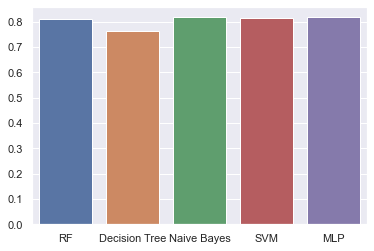

In [24]:
classifiers = ['RF', 'Decision Tree', 'Naive Bayes', 'SVM', 'MLP']

num_times = 50

decision_tree_score = sum([run_dt(df) for x in range(num_times)]) / num_times
random_forest_score = sum([run_rf(df) for x in range(num_times)]) / num_times
naive_bayes_score = sum([run_nb(df) for x in range(num_times)]) / num_times
svm_score = sum([run_svm(df) for x in range(num_times)]) / num_times
mlp_score = sum([run_mlp(df) for x in range(num_times)]) / num_times

scores = [random_forest_score, decision_tree_score, naive_bayes_score, svm_score, mlp_score]

print(scores)

sns.barplot(y=scores, x=classifiers)